In [1]:
import plotly.express as px
import scanpy as sc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

### Visualizing model predictions

### First identify seen perturbations

In [2]:
def get_reverse(perts):
    return [t.split('+')[-1]+'+'+t.split('+')[0] for t in perts]

def remove_reverse(perts):
    return list(set(perts).difference(set(get_reverse(perts))))

def remove_duplicates_list(list_):
    import itertools
    list_.sort()
    return list(k for k,_ in itertools.groupby(list_))

from adjustText import adjust_text

def reformat_combo(combo):
    try:
        return '('+combo.split('_')[0]+','+combo.split('_')[1]+')'
    except:
        return '('+combo+')'

In [3]:
norman_adata = sc.read_h5ad('/dfs/user/yhr/snap/perturb_GNN/data/norman_umi/perturb_processed.h5ad')
all_combos = norman_adata.obs['condition'].unique()
all_combos = [c for c in all_combos if 'ctrl' not in c]
all_singles = set([c.strip('+ctrl') for c in norman_adata.obs['condition'] 
                         if ('ctrl+' in c) or ('+ctrl' in c)])

all_combos = set(all_combos)
all_combos_df = [[c.split('+')[0], c.split('+')[1]] for c in all_combos]
all_combos_df = pd.DataFrame(all_combos_df, columns=['Gene1', 'Gene2'])
all_combos_df['seen'] = True

### Read in model predictions

In [4]:
all_transcriptomes = np.load('/dfs/user/yhr/gears2/Evaluation/gears_misc_umi_no_test_all_preds.npy', allow_pickle=True)
all_transcriptomes = all_transcriptomes.item()

keys = []
transcriptomes = []
for k,v in all_transcriptomes.items():
    keys.append(k)
    transcriptomes.append(v)
keys = np.array(keys)
non_single_idx = np.where(['_'in ki for ki in keys])[0]
seen_singles_idx = np.where(['_' not in ki for ki in keys])[0]

In [16]:
import umap
fit = umap.UMAP()
u = fit.fit_transform(transcriptomes)

In [ ]:
seen_combos_idx = []
for itr, ki in enumerate(keys):
    if '_' not in ki:
        continue
    key1 = '+'.join(ki.split('_')) in all_combos
    key2 = get_reverse(['+'.join(ki.split('_'))])[0] in all_combos           
    if (key1 == True) or (key2 == True):
        seen_combos_idx.append(itr)

In [18]:
result_adata = sc.AnnData(np.array(transcriptomes))
result_adata.obs['pert'] = keys
result_adata.var.index = norman_adata.var.gene_name
result_adata.obsm['X_umap'] = u
result_adata.obs['seen'] = False
result_adata.obs['seen'][seen_combos_idx] = True
result_adata.obs['seen'][seen_singles_idx] = True
result_adata.obs['seen_int']=result_adata.obs['seen'].astype('int')

/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
sc.pp.neighbors(result_adata, use_rep='X')
sc.tl.leiden(result_adata)

#result_adata.write_h5ad('gears_misc_umi_no_test_leavecluster_strict_all_preds.h5ad')

### Visualize clusters

In [11]:
adata[adata.obs['seen']==True]

View of AnnData object with n_obs × n_vars = 230 × 5054
    obs: 'pert', 'seen', 'seen_int', 'leiden'
    uns: 'leiden', 'neighbors'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

In [8]:
# adata = result_adata

# OR
adata = sc.read_h5ad('/dfs/user/yhr/gears2/Evaluation/gears_misc_umi_no_test_all_preds.h5ad')

/dfs/user/yhr/deepamp/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [21]:
# For Revier 2 Question 8

remove_perts = ['IKZF3',
 'FEV_MAP7D1',
 'FEV_ISL2',
 'AHR_FEV',
 'CBFA2T3_FEV',
 'ETS2_IKZF3',
 'FOSB_IKZF3']


In [22]:
u = adata.obsm['X_umap']
keys = adata.obs['pert'].values
non_single_idx = np.where(['_'in ki for ki in keys])[0]

### Cluster plots - GEARS

In [6]:
seen_adata = adata[adata.obs['seen'] == True]
sc.pp.neighbors(seen_adata, use_rep='X')
sc.tl.umap(seen_adata)
sc.tl.leiden(seen_adata)

In [7]:
clusters2keep = [18, 0, 13, 6, 7, 12, 16, 15, 3, 17]
#clusters2keep = [17]

unseen_cluster_dict = {18: 'Pro Growth',
                       0: 'Pro Growth',
                       13:'Pro Growth',
                       
                       6: 'Pioneer Factors',
                       7: 'Pioneer Factors',
                       
                       12: 'Megakaryocyte Marker',
                       
                       16: 'Granulocyte Marker',
                       15: 'Granulocyte Marker',
                       
                       3:'Erythroid Marker',
                       
                       17: 'High Erythroid Marker Expression (New)',

                      -1: 'Other Predicted'}

In [8]:
tab10_colors = {
    'Granulocyte Marker': '#e377c2',
    'Pioneer Factors': '#ff7f0e', 
    'Pro Growth': '#2ca02c', 
    'Megakaryocyte Marker':'#d62728', 
    'Erythroid Marker':'#9467bd',
    'Other Predicted':'#8c564b',
    'High Erythroid Marker Expression (New)': '#1f77b4' }

In [9]:
cluster_idx = adata.obs['leiden'].astype(int).values
cluster_idx2remove = np.where([(c not in clusters2keep) for c in cluster_idx])[0]
cluster_idx[cluster_idx2remove]=-1
adata.obs['mod_leiden'] = cluster_idx
adata.obs['mod_leiden_names'] = [unseen_cluster_dict[c] for c in cluster_idx]

unseen_plot_adata = adata[adata.obs['seen']==False]
unseen_plot_umap = unseen_plot_adata.obsm['X_umap']
unseen_cluster_idx = unseen_plot_adata.obs['mod_leiden'].values
unseen_cluster_names = [unseen_cluster_dict[c] for c in unseen_cluster_idx]

In [70]:
#tab10_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
#          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
#          '#bcbd22', '#17becf']

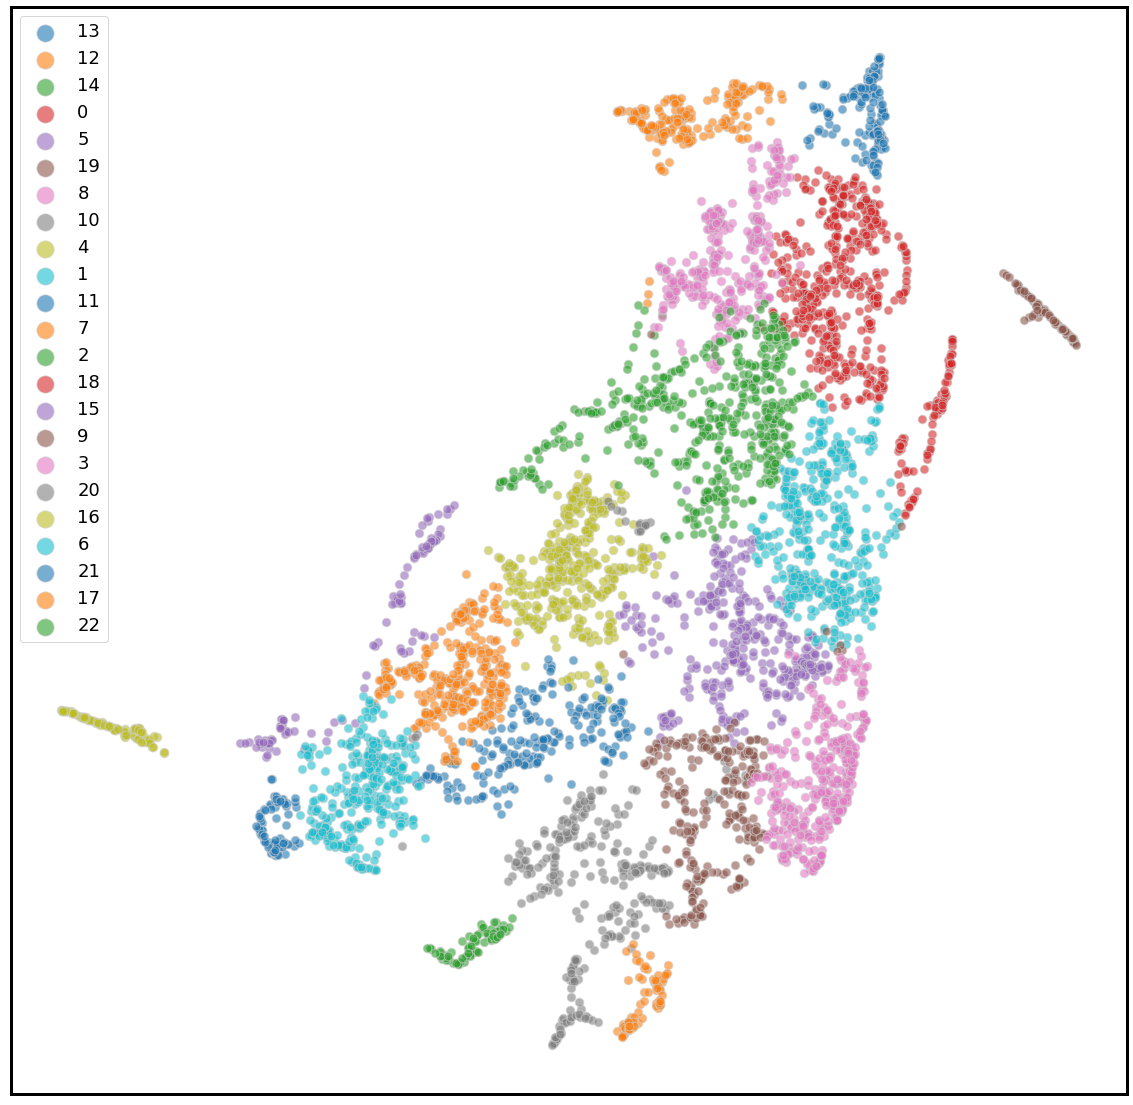

In [10]:
# All clusters plot for supplementary

plt.figure(figsize= [20,20])

for idx in list(adata.obs.leiden.unique()):
    plot_df = adata[adata.obs['leiden'] == idx]
    plt.scatter(plot_df.obsm['X_umap'][:,0], 
                plot_df.obsm['X_umap'][:,1], 
                s=75, edgecolors='lightgray', 
                alpha=0.6,
                marker='o')

"""
seen_plot_data = adata[adata.obs['seen']==True]
seen_plot_umap = seen_plot_data.obsm['X_umap']
seen_cluster_idx = seen_plot_data.obs['mod_leiden'].values

plt.scatter(seen_plot_umap[:,0], seen_plot_umap[:,1], s=55, edgecolors='lightgray', 
            c='black',
            cmap='tab10', marker='X')
"""
    
plt.legend(list(adata.obs.leiden.unique()),
          fontsize=18, markerscale=2)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('3')  

#plt.legend(['Novel phenotype', 'Seen'])

/tmp/user/20138/ipykernel_2782862/3374814401.py:39: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('fig3.svg', bbox_inches='tight', figsize=(width, height))


"\ntexts = [plt.text(adata.obsm['X_umap'][idx,0], adata.obsm['X_umap'][idx,1], \n                  reformat_combo(adata.obs.iloc[idx,:]['pert']), fontsize=18) \n                  for idx in range(len(adata)) if adata.obs.loc[str(idx), 'pert'] in remove_perts]\n_ = adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))\n"

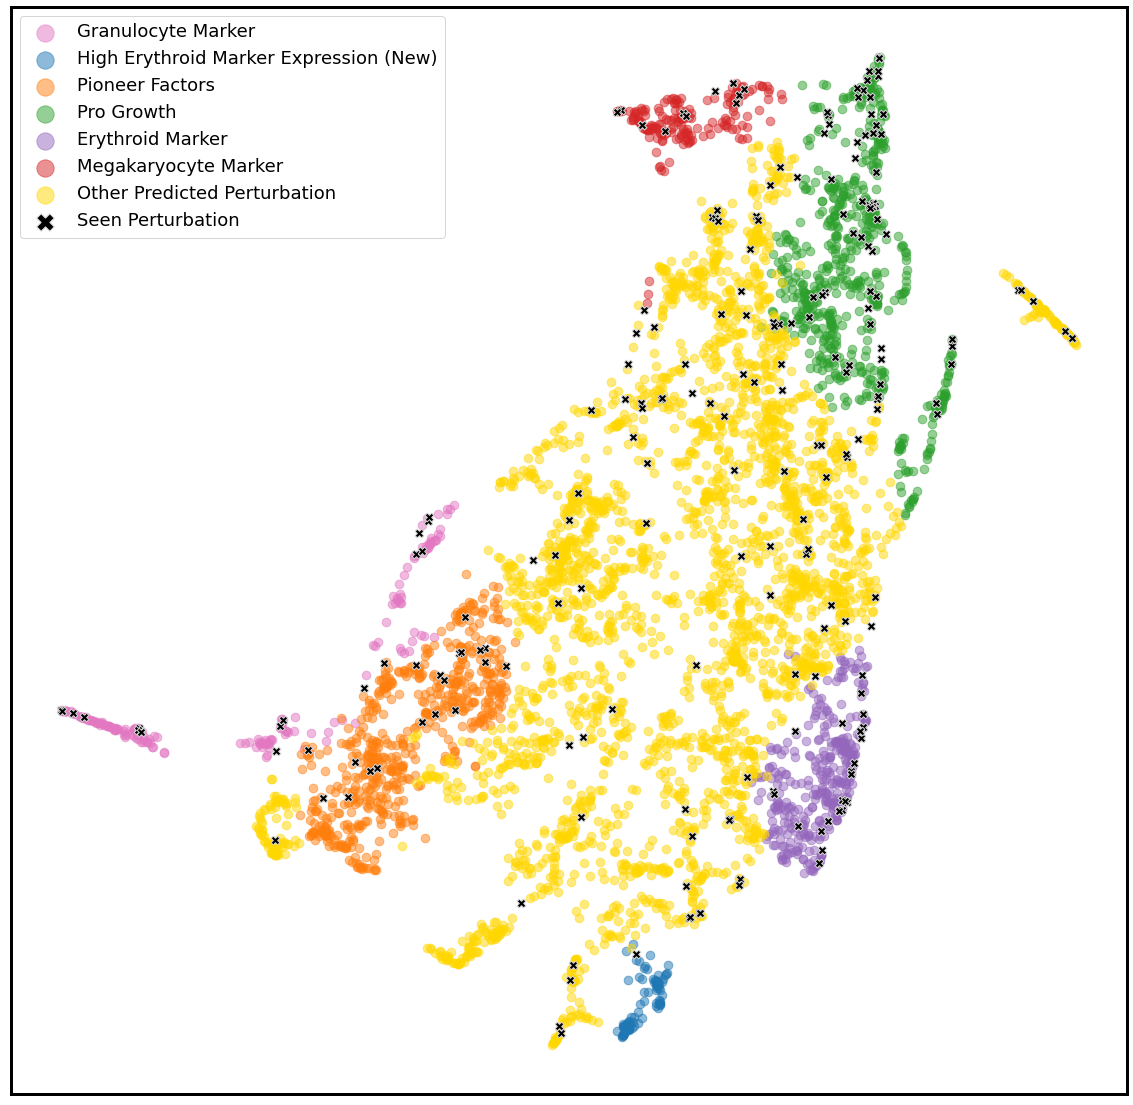

In [13]:

plt.figure(figsize= [20,20])
unseen_cluster_names_unique = list(set(unseen_cluster_names).difference(set(['Other Predicted'])))

for i, name in enumerate(unseen_cluster_names_unique):
    plot_df = unseen_plot_adata[unseen_plot_adata.obs['mod_leiden_names'] == name]
    plt.scatter(plot_df.obsm['X_umap'][:,0], 
                plot_df.obsm['X_umap'][:,1], 
                s=75, edgecolors=None, alpha=0.5,
                c=tab10_colors[name],
                marker='o')

plot_df = unseen_plot_adata[unseen_plot_adata.obs['mod_leiden'] == -1]
plt.scatter(plot_df.obsm['X_umap'][:,0], 
            plot_df.obsm['X_umap'][:,1], 
            s=75, edgecolors=None, alpha=0.5,
            c='gold', marker='o')

seen_plot_data = adata[adata.obs['seen']==True]
seen_plot_umap = seen_plot_data.obsm['X_umap']
seen_cluster_idx = seen_plot_data.obs['mod_leiden'].values

plt.scatter(seen_plot_umap[:,0], seen_plot_umap[:,1], s=75, edgecolors='lightgray', 
            c='black',
            cmap='tab10', marker='X')
    
plt.legend(unseen_cluster_names_unique + 
           ['Other Predicted Perturbation'] +
           ['Seen Perturbation'], fontsize=18, markerscale=2)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('3')  

width = 3.692913
height = 3.6011811
plt.savefig('fig3.svg', bbox_inches='tight', figsize=(width, height))

"""
texts = [plt.text(adata.obsm['X_umap'][idx,0], adata.obsm['X_umap'][idx,1], 
                  reformat_combo(adata.obs.iloc[idx,:]['pert']), fontsize=18) 
                  for idx in range(len(adata)) if adata.obs.loc[str(idx), 'pert'] in remove_perts]
_ = adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
"""

### Marker gene plots

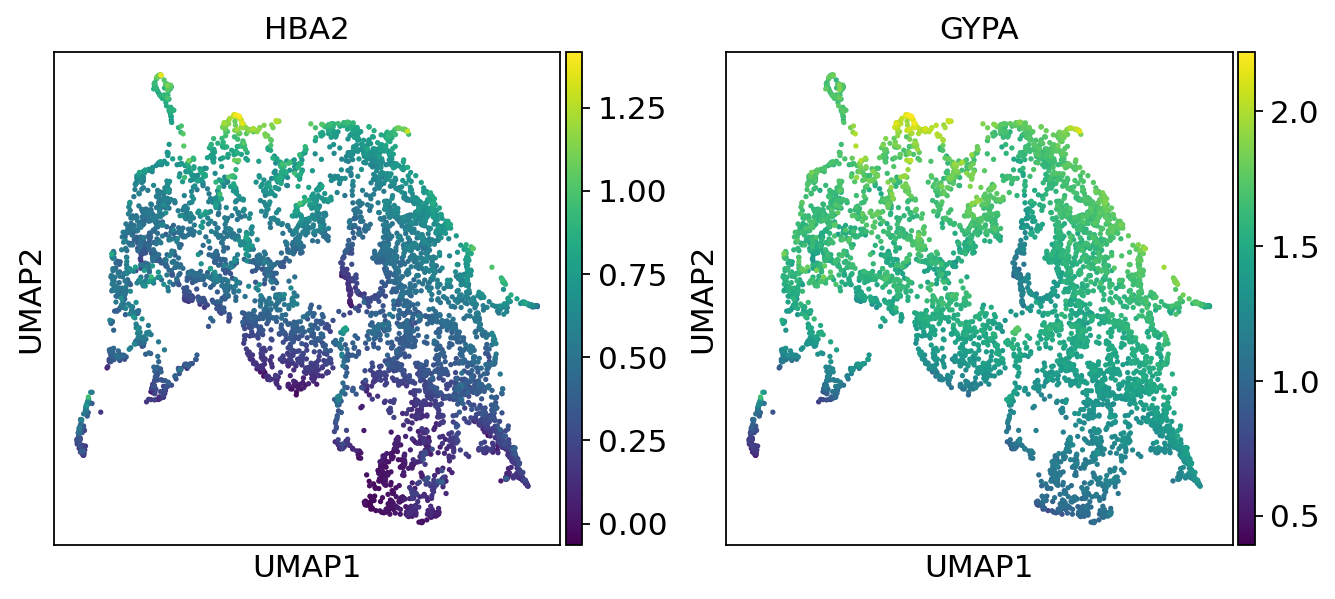

In [15]:
sc.set_figure_params(figsize=[4,4])
sc.pl.umap(adata, color=['HBA2', 'GYPA'])

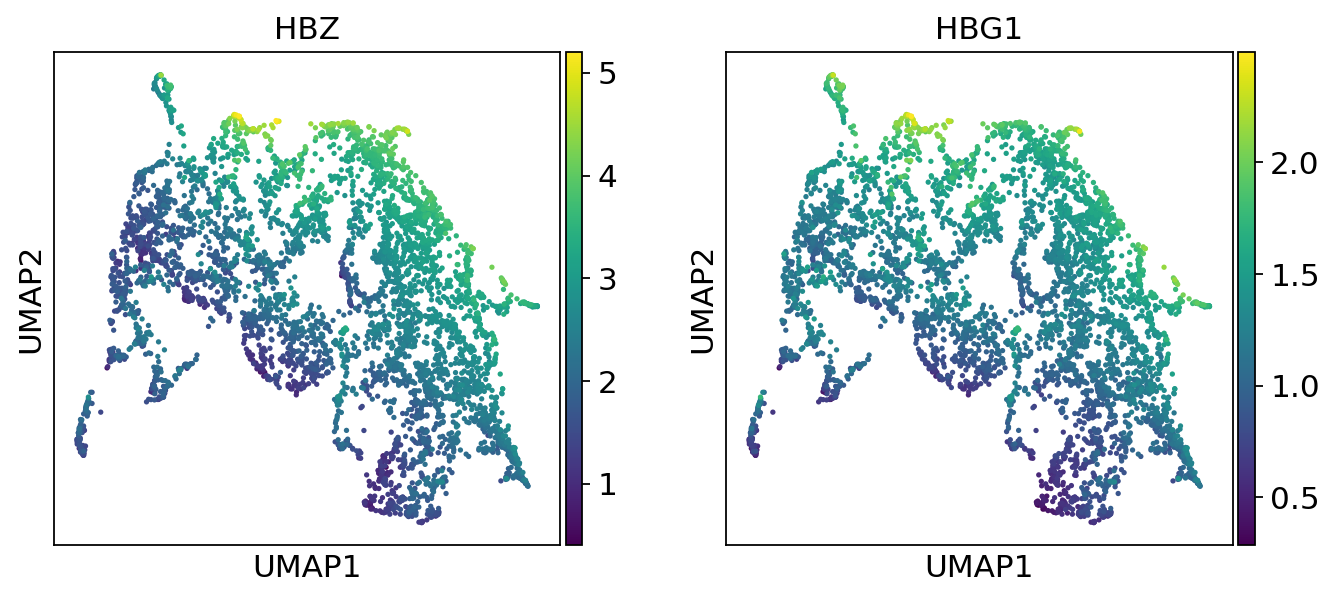

In [16]:
sc.set_figure_params(figsize=[4,4])
sc.pl.umap(adata, color=['HBZ', 'HBG1'])

### Max Analysis

In [ ]:
marker_genes = ['HBA2', 'GYPA', 'HBZ']

In [ ]:
max_seen

In [ ]:
(max_unseen-max_seen)/max_seen

In [ ]:
subset_unseen = adata[adata.obs['seen']==False]
max_unseen = subset_unseen[:,marker_genes].X.max(0)

In [ ]:
np.argsort(subset_unseen[:,marker_genes].X[:,1])

In [ ]:
subset_unseen.obs['pert'][3213]

In [ ]:
subset_unseen[:,marker_genes].X[3213,:]

In [ ]:
subset_seen = adata[adata.obs['seen']==True]
max_seen = subset_seen[:,marker_genes].X.max(0)

In [ ]:
ind = np.arange(3)  # the x locations for the groups
width = 0.25

In [ ]:
ctrl_adata = norman_adata[norman_adata.obs['condition']=='ctrl']
ctrl_adata.var = ctrl_adata.var.set_index('gene_name')
baseline = ctrl_adata[:,marker_genes].X.toarray().mean(0)

In [ ]:
fig, ax = plt.subplots(figsize=(6.5,3))
rects1 = ax.bar(ind - width/2, max_unseen-baseline, width,
                label='Unseen perturbations in this cluster', color='royalblue')
rects2 = ax.bar(ind + width/2, max_seen-baseline, width, 
                label='All seen perturbations', color='red')

ax = plt.gca()
ax.grid(False)

plt.legend()
ax = plt.gca()
ax.set_xticks([0,1,2])
_ = ax.set_xticklabels(marker_genes)
plt.xlabel('Marker Genes for Erythroid Lineage')
plt.ylabel('Maximum\n post-perturbation \n gene expression')

plt.title('GEARS predicts novel double perturbations to more \n' 
          'efficiently increase erythroid marker expression')

### Applying a perturbation to TS

In [ ]:
#hematopoietic_mean = aligned_new[aligned_new.obs['cell_ontology_class'] == 'hematopoietic stem cell'].X.toarray().mean(0)

BM_adata_small = BM_adata[:, aligned_new.var.index]
hematopoietic_mean = BM_adata_small[BM_adata_small.obs['cell_ontology_class'] == 'hematopoietic stem cell'].X.toarray().mean(0)


In [ ]:
TS_perts = sc.AnnData(hematopoietic_mean + pert_de)
TS_perts.obs['label'] = 'TS_perts'
TS_perts.obs['pert'] = adata.obs['pert'].values
TS_perts.var.index=aligned_new.var.index

In [ ]:
corrected = scanorama.integrate_scanpy([BM_adata, TS_perts])

In [ ]:
BM_adata_perts_scanorama = sc.concat([BM_adata, TS_perts], join='outer')

In [ ]:
sc.pp.pca(BM_adata_perts_scanorama)
sc.pp.neighbors(BM_adata_perts_scanorama, use_rep='X_pca')

In [ ]:
sc.tl.umap(BM_adata_perts_scanorama)